# Diversification analysis

In [32]:
## Reload changed code
%run ../notebook_preamble.ipy


import altair as alt
from sg_covid_impact.descriptive import *
from sg_covid_impact.utils.altair_save_utils import *
from sg_covid_impact.diversification import *
from sg_covid_impact.make_sic_division import extract_sic_code_description


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Analysis

In [2]:
# Lookups
_SECTION_DIVISION_LOOKUP, _SECTION_NAME_LOOKUP = make_section_division_lookup()

_DIVISION_NAME_LOOKUP = extract_sic_code_description(load_sic_taxonomy(), "Division")

### Calculate sectoral exposure

In [3]:
# Calculate sectoral exposure
d = read_search_trends()
trends_normalised = search_trend_norm(d)
exposures_ranked = rank_sector_exposures(trends_normalised,'division',quantile=np.arange(0,1.1,0.1))
exposures_ranked['division_name'] = exposures_ranked['division'].map(_DIVISION_NAME_LOOKUP)
division_month_exposure_dict = exposures_ranked.set_index(['division','month'])['rank'].to_dict()

my_divisions = list(set(exposures_ranked['division']))

In [10]:
bres = read_official()
exposure_levels = exposures_ranked.merge(bres,left_on='division',right_on='division')
exposure_lad_detailed = make_exposure_shares_detailed(exposure_levels,'geo_nm')

In [25]:
sh = read_shape()

### Make sector space

In [5]:
pr = load_predicted()
pr_selected = pr[my_divisions]

In [7]:
t = extract_sectors(pr_selected,0.5)
div_space = extract_network(t)
p,g,l = make_sector_space_base(sector_space=div_space,extra_edges=70)

#### National network

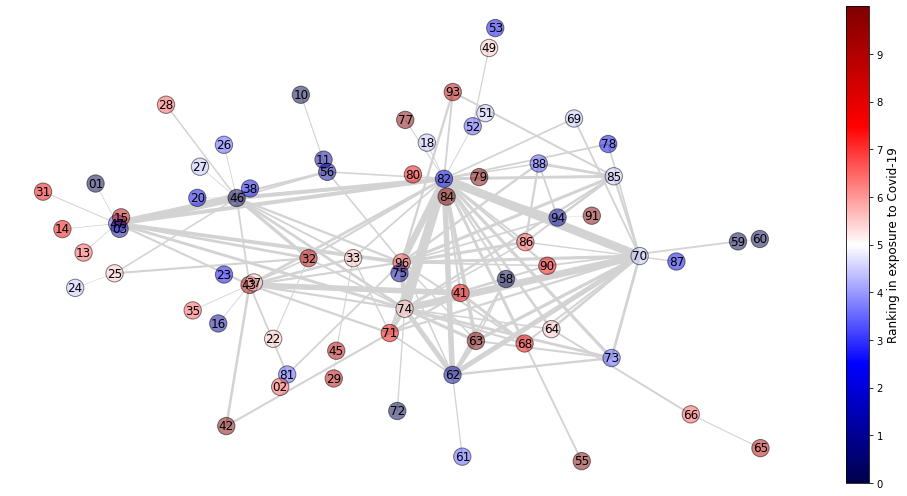

In [9]:
plot_nat_network(g,p,l,division_month_exposure_dict,4,'seismic')

#### Local network

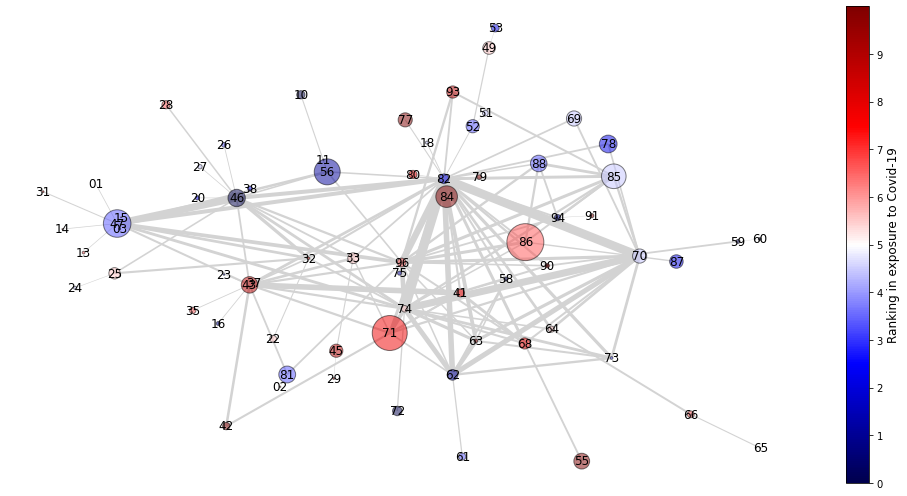

In [19]:
plot_local_network(g,p,l,division_month_exposure_dict,4,
              "Aberdeen City",exposure_lad_detailed,
              'seismic',scale=10000)

#### Measure diversification options


In [21]:
exp_all_months = pd.concat([(make_diversification_options(
    g,division_month_exposure_dict,m,
    [7,8,9],[0,1,2,3]).sort_values('mean',ascending=False)
       .assign(name=lambda x: x['division'].map(_DIVISION_NAME_LOOKUP))
                  .assign(month=m)) for m in range(3,11)])

In [23]:
neighb_shares = make_neighbor_shares(g,division_month_exposure_dict,4)

In [24]:
plot_exposure_neighbours(neighb_shares)

alt.HConcatChart(...)

#### Diversification option maps

In [27]:
# Create diversification shares per lad
monthly_diversification_rankings = pd.concat([
    (make_diversification_options(
        g,division_month_exposure_dict,m,[7,8,9],[0,1,2,3])
     .sort_values('mean',ascending=False)
     .assign(divers_ranking = lambda x: pd.qcut(-x['mean'],q=np.arange(0,1.1,0.25),labels=False))
     .assign(month=m)) for m in range(3,11)])                           

In [29]:
# Merge with diversification information
diversification_lad_detailed = (make_exposure_shares_detailed(exposure_levels,geo='geo_cd')
                                .merge(monthly_diversification_rankings,
                                      left_on=['division','month'],
                                      right_on=['division','month'],
                                      how='outer'))

diversification_lad_detailed['divers_ranking'] = diversification_lad_detailed['divers_ranking'].fillna('Less exposed')

In [30]:
diversification_shares = (make_exposure_shares(
    diversification_lad_detailed,geography='geo_cd',variable='divers_ranking')
                          .query("divers_ranking != 'Less exposed'"))

In [31]:
plot_time_choro(sh,diversification_shares,month=4,exposure=3,exposure_var='divers_ranking',
               name='low diversification')

alt.LayerChart(...)